В этом домашнем задании две части:
* в первой части вы попрактикуетесь в использовании различных имплементаций бустинга
* во второй части потренируетесь снижать размерность с помощью метода главных компонент, а также используете методы кластеризации для задач компьютерного зрения

 # Часть 1. Бустинг

In [1]:
import numpy as np
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error

## Прогнозируем задержки самолётов (3 балла)

Поработаем с задачей про задержки самолётов. На основании доступных данных о рейсе вам нужно определить, будет ли он задержан на 15 минут.
Воспользуйтесь любыми подходами к обработке данных, а также методами градиентного бустинга (XGboost, catboost, LightGBM) и GridSearch для достижения результата. Получите 2 балла за преодоление порога roc_auc_score 0.72 на кросс-валидации и ещё 1 балл за преодоление порога 0.74.

За получение любого значения roc_auc_score < 0.72 (построение модели и вывод на экран некоторого числа) получаете 1 балл.

In [2]:
import pandas as pd

data = pd.read_csv('flight_delays.csv')

In [6]:
data.dtypes

Month                object
DayofMonth           object
DayOfWeek            object
DepTime               int64
UniqueCarrier        object
Origin               object
Dest                 object
Distance              int64
dep_delayed_15min    object
dtype: object

In [29]:
y = data['dep_delayed_15min']
X = data.iloc[:,:-1]
X

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732
1,c-4,c-20,c-3,1548,US,PIT,MCO,834
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423
...,...,...,...,...,...,...,...,...
99995,c-5,c-4,c-3,1618,OO,SFO,RDD,199
99996,c-1,c-18,c-3,804,CO,EWR,DAB,884
99997,c-1,c-24,c-2,1901,NW,DTW,IAH,1076
99998,c-4,c-27,c-4,1515,MQ,DFW,GGG,140


In [30]:
y  = (y  == 'Y').astype(int)

In [31]:
y

0        0
1        0
2        0
3        0
4        1
        ..
99995    0
99996    0
99997    0
99998    0
99999    0
Name: dep_delayed_15min, Length: 100000, dtype: int64

In [32]:
y.value_counts(normalize=True)

0    0.80956
1    0.19044
Name: dep_delayed_15min, dtype: float64

In [33]:
X['Month'] = X.Month.apply(lambda x: int(x.split('-')[1]))
X['DayOfWeek'] = X.DayOfWeek.apply(lambda x: int(x.split('-')[1]))
X['DayofMonth'] = X.DayofMonth.apply(lambda x: int(x.split('-')[1]))
X

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,8,21,7,1934,AA,ATL,DFW,732
1,4,20,3,1548,US,PIT,MCO,834
2,9,2,5,1422,XE,RDU,CLE,416
3,11,25,6,1015,OO,DEN,MEM,872
4,10,7,6,1828,WN,MDW,OMA,423
...,...,...,...,...,...,...,...,...
99995,5,4,3,1618,OO,SFO,RDD,199
99996,1,18,3,804,CO,EWR,DAB,884
99997,1,24,2,1901,NW,DTW,IAH,1076
99998,4,27,4,1515,MQ,DFW,GGG,140


In [34]:
cat_cols = X.columns[X.dtypes == 'object'].tolist()
cat_cols

['UniqueCarrier', 'Origin', 'Dest']

In [35]:
for i in cat_cols:
  display(X[i].value_counts(normalize=True))

WN    0.15082
AA    0.09418
DL    0.08128
MQ    0.07443
OO    0.07390
UA    0.06876
US    0.06482
NW    0.06403
XE    0.05901
OH    0.04594
CO    0.04334
EV    0.03930
FL    0.03039
AS    0.02222
YV    0.02128
B6    0.01838
HP    0.01378
F9    0.01006
DH    0.00966
HA    0.00762
TZ    0.00446
AQ    0.00234
Name: UniqueCarrier, dtype: float64

ATL    0.05834
ORD    0.04870
DFW    0.04270
LAX    0.03259
IAH    0.03048
        ...   
VIS    0.00001
GST    0.00001
ILG    0.00001
WYS    0.00001
ADK    0.00001
Name: Origin, Length: 289, dtype: float64

ATL    0.05795
ORD    0.04933
DFW    0.04337
LAX    0.03205
IAH    0.03056
        ...   
LWB    0.00001
ACK    0.00001
TTN    0.00001
TEX    0.00001
VCT    0.00001
Name: Dest, Length: 289, dtype: float64

In [51]:
from category_encoders.target_encoder import TargetEncoder
tgt_enc = TargetEncoder(cols=['UniqueCarrier', 'Origin','Dest'], smoothing=1) #кодируем категориальные признаки с помощью TargetEncoder
X = tgt_enc.fit_transform(X, y)

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=241)

In [73]:
xgb = XGBClassifier(n_estimators=95, verbosity=0, use_label_encoder =False)
xgb.fit(X_train, y_train)

print(roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1]))

0.7431497284787324


#### Преодолен порог 0.74

 # Часть 2. Обучение без учителя.

## Задание 1. Кластеризация (3 балла)

Задача [кластеризации](https://en.wikipedia.org/wiki/Cluster_analysis) данных является одним из примеров задач обучения "без учителя". Она заключается в разбиении множества объектов на заданное число кластеров, при этом предполагается, что внутри одного кластера будут находиться похожие между собой объекты. Одним из примеров методов кластеризации является алгоритм [KMeans](https://en.wikipedia.org/wiki/K-means_clustering).

### Выбор числа кластеров

Для некоторых алгоритмов кластеризации число кластеров является гиперпараметром (например, в случае KMeans). Поэтому для выбора количества кластеров может быть испоьзован следующий подход: при фиксированной метрики качества для разного числа кластеров вычисляют кластеризацию и выбирают то значение, начиная с которого качество "стабилизируется".

### Метрики качества

Оценивание качества построенной кластеризации не всегда тривиальная задача, так как следует учитывать такие факты как:
 - объекты одного класса должны быть более похоже, чем объекты других кластеров, относительно некоторой заданной метрики похожести
 - метрика не должна учитывать абсолютные значения меток объектов, попавших в кластер (в случае, если истинные метоки известны)

При выполнении задания для оценки качества получившейся кластеризации воспользуемся следующими метриками:
 - [Homogeneity и Completeness](http://scikit-learn.org/stable/modules/clustering.html#homogeneity-completeness-and-v-measure) 
 - [Adjusted Rand index](http://scikit-learn.org/stable/modules/clustering.html#adjusted-rand-index) 
 - [Silhouette Coefficient](http://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient)

Загрузите набор данных [digits](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html). Перед применением алгоритмов не забудьте перемешать изображения в случайном порядке.

#### Загрузим набор данных digits.

(1797, 64)


<Figure size 432x288 with 0 Axes>

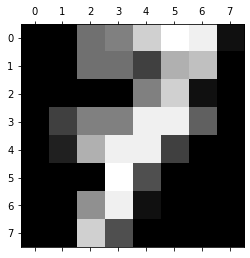

In [4]:
from sklearn.datasets import load_digits
from sklearn.utils import shuffle
digits = load_digits()
print(digits.data.shape)
import matplotlib.pyplot as plt
plt.gray()
plt.matshow(digits.images[7])
plt.show()
#посмотрим на случайно выбранное изображение

In [176]:
X, y = digits.data, digits.targetX, y = digits.data, digits.target


Im = digits.images

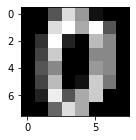

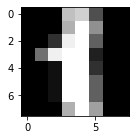

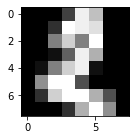

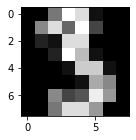

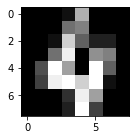

In [177]:
#Выведем на экран первые 5 цифр (в цветовой схеме 'gray') - изображения идут по порядковым номерам. 
for i in range(5):
    plt.figure(figsize=(2,2))
    plt.imshow(Im[i], cmap='gray')
    plt.show()

#### Перемешаем изображения в случайном порядке. Для этого воспользуемся функцией разделения и объединения выборки с функцией  shuffle=True.

In [180]:
X_train, X_test, y_train, y_test, Im_train, Im_test = train_test_split(X, y, Im, test_size=0.2, shuffle=True,
                       stratify=y, random_state=0)

X = np.r_[X_train, X_test]
y = np.r_[y_train, y_test]
Im = np.r_[Im_train, Im_test]
print('X shape: ', X.shape)
print('y shape: ', y.shape)
print('Image shape: ', Im.shape)

X shape:  (1797, 64)
y shape:  (1797,)
Image shape:  (1797, 8, 8)


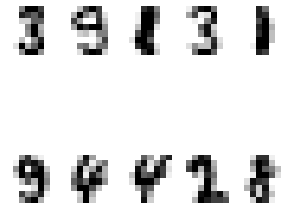

In [181]:
#проверим, что изображения перемешаны
n_rows = 2
n_cols = 5
from itertools import product

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5, 5))
k = 0
for i, j in product(range(n_rows), range(n_cols)):
    image = Im[n_cols * i + j]
    ax[i, j].imshow(image, cmap='binary', interpolation='none')
    ax[i, j].axis('off')

plt.show()
plt.close()

Кластеризуйте изображения при помощи алгоритма [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), подобрав число кластеров для некоторой фиксированной метрики из указанных выше. Рассмотрите различные способы выбора начального приближения (параметр *init*). Оцените качество получившейся кластеризации используя все описанные выше метрики. Визуализируйте изображения, соответствующие центроидам лучшей кластеризации.

In [190]:
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
import numpy as np
import random

from matplotlib import pylab as plt
%pylab inline

km = KMeans(n_clusters=10, init='k-means++', max_iter=100, n_init=2) #параметр init = 'k-means++'
km.fit(X)
labels = y

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))

print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

order_centroids = km.cluster_centers_.argsort()[:, ::-1]



Populating the interactive namespace from numpy and matplotlib
Homogeneity: 0.738
Completeness: 0.756
Adjusted Rand-Index: 0.651
Silhouette Coefficient: 0.189


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [226]:
km2 = KMeans(n_clusters=10, init='random', max_iter=100, n_init=2)  #параметр init = 'random'
km2.fit(X)

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km2.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km2.labels_))

print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km2.labels_))

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km2.labels_, sample_size=1000))


Homogeneity: 0.697
Completeness: 0.732
Adjusted Rand-Index: 0.573
Silhouette Coefficient: 0.185


Вывод
#### Кластеры хорошо совпадают с классами, но сами кластеры не очень хорошие - Silhouette Coefficient: 0.189. Лучший способ   выбора начального приближения - 'k-means++'

#### Визуализируем изображения, соответствующие центроидам лучшей кластеризации.

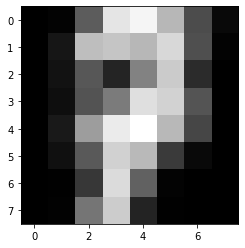

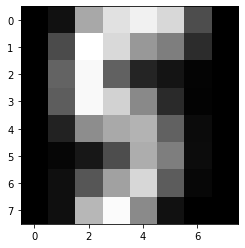

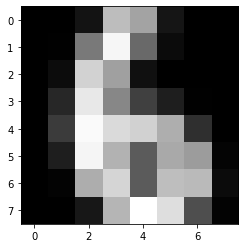

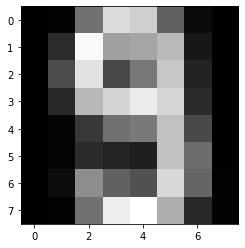

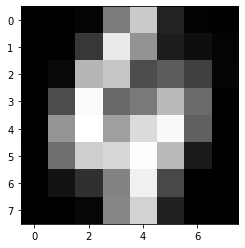

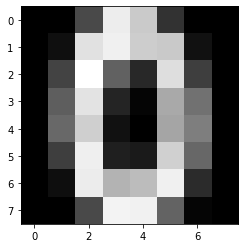

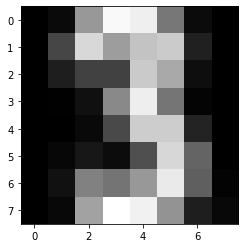

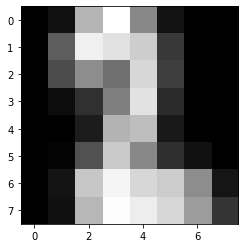

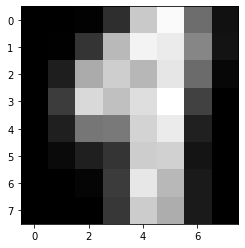

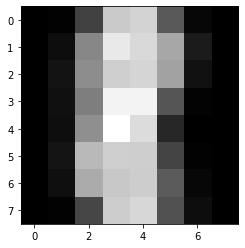

In [222]:
def clusters_centers(data, num_clusters, init0):
    estimator = KMeans(init=init0, n_clusters=num_clusters)
    estimator.fit(data)
    
    centers = estimator.cluster_centers_
    for elem in centers:
        elem = elem.reshape((8,8))
        plt.imshow(elem, interpolation='none')
        plt.show()
        
clusters_centers(X, 10, 'k-means++')

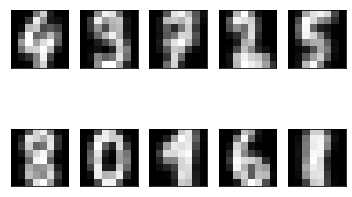

In [193]:
#для большей наглядности отобразим картинки в уменьшенном виде
_, axes = plt.subplots(2, 5)
for ax, center in zip(axes.ravel(), km.cluster_centers_):
    ax.matshow(center.reshape(8, 8), cmap=plt.cm.gray)
    ax.set_xticks(())
    ax.set_yticks(())

Вывод

#### Центроиды кластеров похожи на цифры - хороший результат

Не всегда бывает удобно работать с полной матрицей объект-признак, например, для случая визуализации данных. Можно применить метод уменьшения размерности *PCA*. Вот [здесь](http://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#example-manifold-plot-lle-digits-py) было показано сравнение различных способов сжатия размерности для проекции на плоскость. На изображениях видно, что некоторые преобразования дают неплохую картину и одинаковые цифры расположены близко друг к другу. Посмотрим, поможет ли это на практике.
 
Примените преобразования [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) и [tSNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) (для числа компонент 2 и 10) и сравните результаты с предыдущими. Нашелся ли метод кластеризации, превосходящий другие по всем метрикам? Являются ли все три метрики согласованными? Можете ли вы объяснить почему?

Projecting 64-dimensional data to 2D


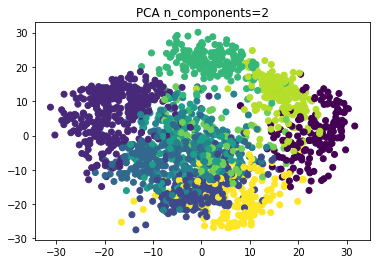

Homogeneity: 0.524
Completeness: 0.528
Adjusted Rand-Index: 0.390
Silhouette Coefficient: 0.395
CPU times: user 738 ms, sys: 41.7 ms, total: 779 ms
Wall time: 459 ms


In [233]:
%%time

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

print('Projecting %d-dimensional data to 2D' % X.shape[1])

plt.scatter(X_reduced[:,0], X_reduced[:,1], c=km.labels_, cmap='viridis')
plt.title('PCA n_components=2');
plt.show() #кластеры выделяются, но накладываются
km_pca2 = KMeans(n_clusters=10, init='k-means++', max_iter=100, n_init=2)  #параметр init = 'random'
km_pca2.fit(X_reduced)

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km_pca2.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km_pca2.labels_))

print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km_pca2.labels_))

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_reduced, km_pca2.labels_, sample_size=1000))

Projecting 64-dimensional data to 2D


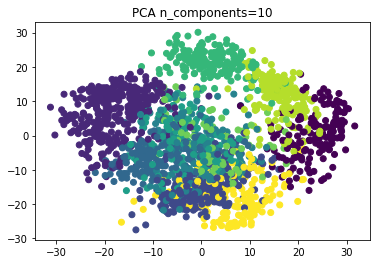

Homogeneity: 0.501
Completeness: 0.507
Adjusted Rand-Index: 0.353
Silhouette Coefficient: 0.381
CPU times: user 725 ms, sys: 47.4 ms, total: 773 ms
Wall time: 479 ms


In [238]:
%%time


pca_10 = PCA(n_components=10)
X_reduced10 = pca.fit_transform(X)

print('Projecting %d-dimensional data to 2D' % X.shape[1])

plt.scatter(X_reduced10[:,0], X_reduced10[:,1], c=km.labels_, cmap='viridis')
plt.title('PCA n_components=10');
plt.show() #кластеры выделяются, но накладываются

km_pca10 = KMeans(n_clusters=10, init='k-means++', max_iter=100, n_init=2)  #параметр init = 'random'
km_pca10.fit(X_reduced10)

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km_pca10.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km_pca10.labels_))

print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km_pca10.labels_))

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_reduced10, km_pca10.labels_, sample_size=1000))

PCA с двумя компонентами показывает результат лучше, чем с 10

CPU times: user 38.3 s, sys: 804 ms, total: 39.1 s
Wall time: 12.6 s


Text(0.5, 1.0, 'MNIST. t-SNE projection, n_components=2')

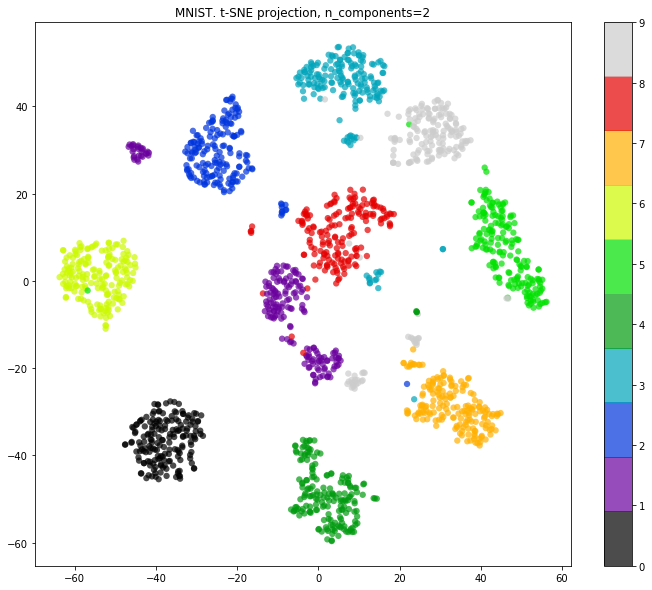

In [219]:
%%time

from sklearn.manifold import TSNE

tsne_2 = TSNE(random_state=17, n_components=2)
X_tsne_2 = tsne_2.fit_transform(X) # две координаты

plt.figure(figsize=(12,10))
plt.scatter(X_tsne_2[:, 0], X_tsne_2[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST. t-SNE projection, n_components=2');

In [237]:
km_tsne_2 = KMeans(n_clusters=10, init='k-means++', max_iter=100, n_init=2)  #параметр init = 'random'
km_tsne_2.fit(X_tsne_2)

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km_tsne_2.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km_tsne_2.labels_))

print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km_tsne_2.labels_))

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_tsne_2, km_tsne_2.labels_, sample_size=1000))

Homogeneity: 0.903
Completeness: 0.904
Adjusted Rand-Index: 0.879
Silhouette Coefficient: 0.633


CPU times: user 7min, sys: 11.9 s, total: 7min 12s
Wall time: 3min 48s


Text(0.5, 1.0, 'MNIST. t-SNE projection, n_components= 10')

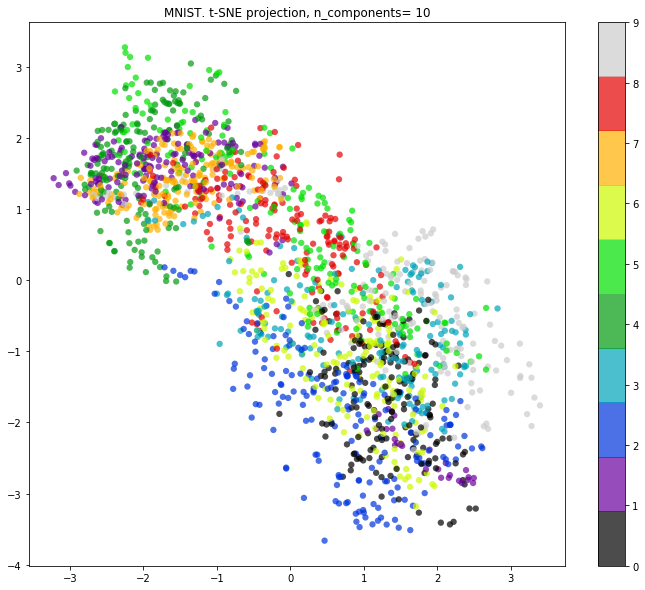

In [218]:
%%time

from sklearn.manifold import TSNE

tsne = TSNE(random_state=17, n_components=10, method='exact')
X_tsne = tsne.fit_transform(X) # две координаты

plt.figure(figsize=(12,10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST. t-SNE projection, n_components= 10');

In [235]:
km_tsne_10 = KMeans(n_clusters=10, init='k-means++', max_iter=100, n_init=2)  #параметр init = 'random'
km_tsne_10.fit(X_tsne)

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km_tsne_10.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km_tsne_10.labels_))

print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km_tsne_10.labels_))

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_tsne, km_tsne_10.labels_, sample_size=1000))

Homogeneity: 0.812
Completeness: 0.831
Adjusted Rand-Index: 0.736
Silhouette Coefficient: 0.338


Вывод:
##### Нашелся ли метод кластеризации, превосходящий другие по всем метрикам - TSNE с двумя компонентами. 
##### Являются ли все три метрики согласованными? Нет. Исходя из полученных результатов по всем методам кластеризации, можно сказать, что Silhouette Coefficient не согласован с двумя другими метриками. Это происходит из-за того, что силуэт - внутренняя метрика качества кластеризации, а остальные - внешние. 

Визуализируйте несколько изображений, которые во всех случаях были отнесены к неправильному кластеру (объект назовем ошибочно отнесенным, если он имеет иную метку класса, нежели большая часть объектов в кластере). Можете ли вы пояснить почему так произошло?

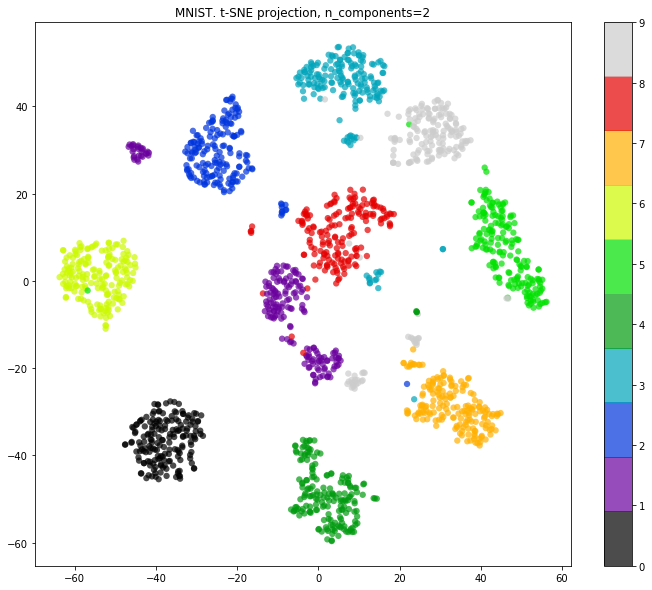

In [270]:
tsne_2 = TSNE(random_state=17, n_components=2)
X_tsne_2 = tsne_2.fit_transform(X) # две координаты

plt.figure(figsize=(12,10))
plt.scatter(X_tsne_2[:, 0], X_tsne_2[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST. t-SNE projection, n_components=2');

Можно заметить, что часть облака "3" находится рядом с "8", а часть облака "1" рядом с "2". 

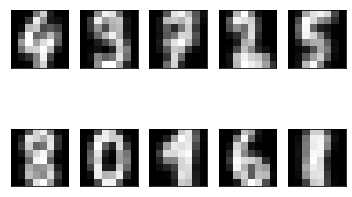

In [271]:
_, axes = plt.subplots(2, 5)
for ax, center in zip(axes.ravel(), km.cluster_centers_):
    ax.matshow(center.reshape(8, 8), cmap=plt.cm.gray)
    ax.set_xticks(())
    ax.set_yticks(())

Вывод цифры 3 и 8 в некоторых случаях практически неотличимы, что создает проблему для категоризаци, неправильное распознавание 1 и 2 может объясняться в сложести правописания, в особенности при наличии нижнего элемента _ у 1. Однако распознавание других цифр в большинстве случаев у метода получается хорошо. 

## Задание 2. Разделение изображения на семантические компоненты (4 балла)

![RedPanda](http://imgur.com/6Aa52Lm.png)

Алгоритмы кластеризации могут применяться в самых разных задачах. Например, в анализе изображений есть задача разделения изображения на семантические компоненты, которую можно решать в том числе с помощью алгоритмов кластеризации. 

In [8]:
from matplotlib.pyplot import imread

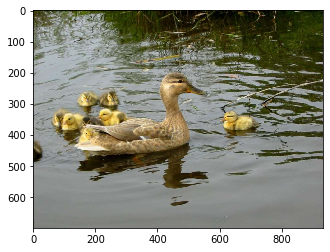

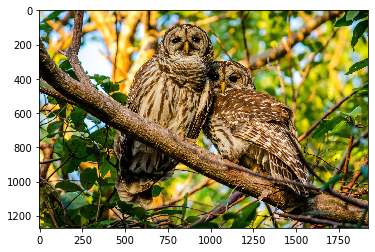

In [9]:
from sklearn.cluster import KMeans
image1 = imread("duck.jpg")
plt.imshow(image1)
plt.show()
image2 = imread("owls.jpg")
plt.imshow(image2)
plt.show()

Для каждого изображения, используя кластеризацию KMeans, выделите компоненты, охарактеризовав каждый пиксель следующим образом: $\psi_i = [\lambda x_i, \lambda y_i, r_i, g_i, b_i]$, где 
$x_i$ и $y_i$ — координаты пикселя, $r_i, g_i, b_i$ — его цвет, $\lambda$ — параметр, выражающий важность пространственной связности перед цветовой похожестью.

In [203]:
def find_components(image, lmbd, n_clusters):
    psy = []
    height, width, channel = image.shape
    for i in range(0, height):
        for j in range(0, width):
            blueComponent = image[i][j][0]
            greenComponent = image[i][j][1]
            redComponent = image[i][j][2]
            psy_i = [lmbd*i, lmbd*j, blueComponent,greenComponent, redComponent]
            psy.append(psy_i)
    km = KMeans(n_clusters= n_clusters, init='k-means++', max_iter=100, n_init=2) #параметр init = 'k-means++'
    km.fit(psy)
    newimg=km.cluster_centers_[km.labels_]
    newimg_2 = newimg[:,2:5]
    newimg_2=np.reshape(newimg_2, (image.shape)) 
    int_array = newimg_2.astype(int)
    return int_array
    
find_components(image1, 0.3, 3)
find_components(image2, 1.5, 3)
#возвращаются сами компоненты в виде цветов каждого пикселя

array([[[150, 133,  84],
        [150, 133,  84],
        [150, 133,  84],
        ...,
        [127, 118,  50],
        [127, 118,  50],
        [127, 118,  50]],

       [[150, 133,  84],
        [150, 133,  84],
        [150, 133,  84],
        ...,
        [127, 118,  50],
        [127, 118,  50],
        [127, 118,  50]],

       [[150, 133,  84],
        [150, 133,  84],
        [150, 133,  84],
        ...,
        [127, 118,  50],
        [127, 118,  50],
        [127, 118,  50]],

       ...,

       [[ 88,  85,  37],
        [ 88,  85,  37],
        [ 88,  85,  37],
        ...,
        [127, 118,  50],
        [127, 118,  50],
        [127, 118,  50]],

       [[ 88,  85,  37],
        [ 88,  85,  37],
        [ 88,  85,  37],
        ...,
        [127, 118,  50],
        [127, 118,  50],
        [127, 118,  50]],

       [[ 88,  85,  37],
        [ 88,  85,  37],
        [ 88,  85,  37],
        ...,
        [127, 118,  50],
        [127, 118,  50],
        [127, 118,  50]]

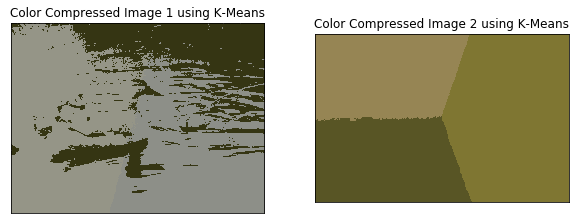

In [209]:
fig = plt.figure(figsize=(10,10)) 
ax=fig.add_subplot(1,2,1,xticks=[],yticks=[],title='Color Compressed Image 1 using K-Means') 
ax.imshow(find_components(image1, 0.3, 3)
) 
ax=fig.add_subplot(1,2,2,xticks=[],yticks=[],title='Color Compressed Image 2 using K-Means') 
ax.imshow(find_components(image2, 1.5, 3))
plt.show() 

Попробуйте выделить сегменты при помощи [спектральной кластеризации](http://scikit-learn.org/stable/modules/clustering.html#spectral-clustering). Обратите внимание на [пример в sklearn](http://scikit-learn.org/0.16/auto_examples/cluster/plot_lena_segmentation.html). Для ускорения работы алгоритма рекомендуется привести изображение к серому цвету. При необходимости можно сжать изображения в 2 раза.

In [226]:
import skimage
from skimage import transform
from skimage import color
from sklearn.feature_extraction.image import img_to_graph
from sklearn.cluster import spectral_clustering
from sklearn.feature_extraction import image as im
def spectral_segmentation(image, n_clusters, method, beta, eps, one_picture):
    lena = image
    graph = im.img_to_graph(lena)
    graph.data = np.exp(-beta * graph.data / lena.std()) + eps
    N_REGIONS = n_clusters
    labels = spectral_clustering(graph, n_clusters=N_REGIONS,
                                 assign_labels=method,
                                 random_state=1)
    labels = labels.reshape(lena.shape)
    plt.figure(figsize=(5, 5))
    plt.imshow(lena,   cmap=plt.cm.gray)
    for l in range(N_REGIONS):
        plt.contour(labels == l, contours=1,
                    colors=[plt.cm.viridis(l / float(N_REGIONS)), ])
    plt.xticks(())
    plt.yticks(())
    
    return plt.show()
    
    #отдельно сегменты можно вывести через labels(то есть после определения labels записать return labels, смотреть в примечании)

Визуализируйте результаты сегментации (аналогично рисунку выше) для обоих методов.

In [229]:
image11 = skimage.color.rgb2gray(image1)
rows, cols = image1.shape[0], image1.shape[1]
image11 = skimage.transform.resize(image11,(int(0.5*rows),int(0.5*cols)))

image22 = skimage.color.rgb2gray(image2)
rows, cols = image2.shape[0], image2.shape[1]
image22 = skimage.transform.resize(image22,(int(0.25*rows),int(0.25*cols))) #для ускорения работы пришлось уменьшить изображение



/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: The following kwargs were not used by contour: 'contours'


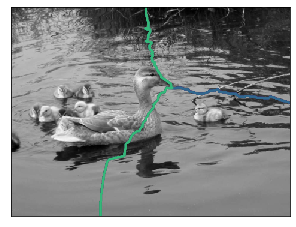

In [227]:
spectral_segmentation(image11, 3, 'kmeans', beta = 5, eps = 1e-6, one_picture = True)

#### Сегментизация разделила изображение на 3 части, хорошо прорисовывая форму клюва птицы. Для заданного числа кластеров результат неплохой, однако с задачей алгоритм справился посредственно. 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: The following kwargs were not used by contour: 'contours'


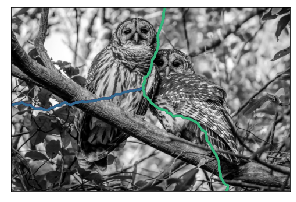

In [232]:
spectral_segmentation(image22, 3, 'kmeans', beta = 3, eps = 1e-6, one_picture = True)


Сегментизация сработала примерно так же, как и в k-means с закрашиванием

Поэкспериментируйте с параметрами алгоритмов. Сравните два подхода и сегментации, к которым они приводят.
Для всех ли изображений в результате сегментации хорошо видны контуры объектов?

##### Не для всех изображений в результате сегментации хорошо видны контуры объектов

Было также попробовано использовать spectral_segmentation для image22 с n_clusters = 11 с помощью Google Colab при использовании двух методов, так как процесс занял 44 минуты 33 секунды, было решено не перезапускать алгоритм с этими показателями. В данном случае алгоритм сработал лучше, чем при количестве кластеров, равных 3. 
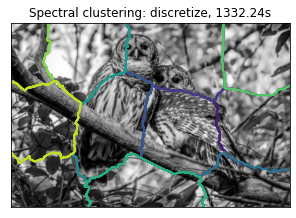
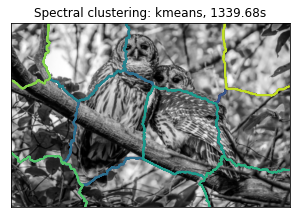
Похожая процедура была проведена с image11
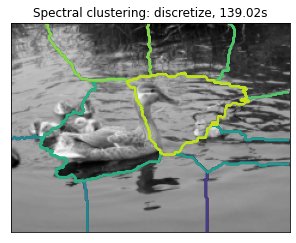
Также было изменено beta = 3, n_clusters = 20. Результат визуально хуже, чем в предыдущем случае.  
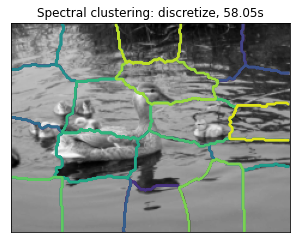
beta= 9, n_clusters = 12. Хорошо выделилось отражение птицы
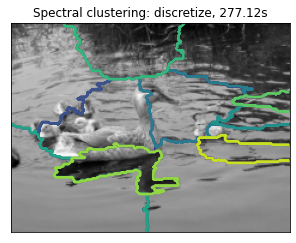

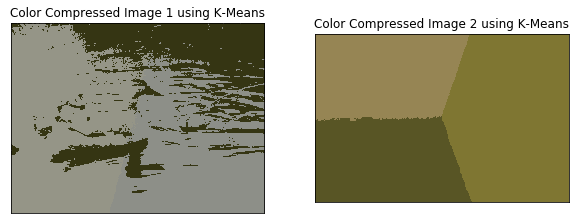

In [209]:
#для ранее описаного метода k-means
fig = plt.figure(figsize=(10,10)) 
ax=fig.add_subplot(1,2,1,xticks=[],yticks=[],title='Color Compressed Image 1 using K-Means') 
ax.imshow(find_components(image1, 0.3, 3)
) 
ax=fig.add_subplot(1,2,2,xticks=[],yticks=[],title='Color Compressed Image 2 using K-Means') 
ax.imshow(find_components(image2, 1.5, 3))
plt.show() 

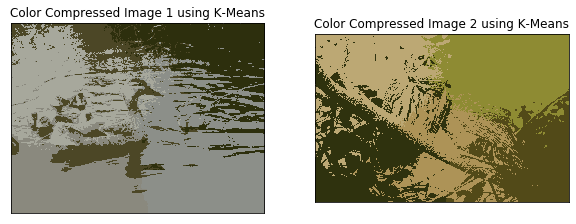

In [237]:
fig = plt.figure(figsize=(10,10)) 
ax=fig.add_subplot(1,2,1,xticks=[],yticks=[],title='Color Compressed Image 1 using K-Means') 
ax.imshow(find_components(image1, 0.2, 5)
) 
ax=fig.add_subplot(1,2,2,xticks=[],yticks=[],title='Color Compressed Image 2 using K-Means') 
ax.imshow(find_components(image2, 0.3, 5))
plt.show() 

Ваш вывод тут

#### Для второго алгоритма требуется значительно больше времени работы. При увеличении числа beta и n_clusters получается выделить некие яркие фрагменты, которые можно распознать в виде фигур. K-means, использованный в первом способе с заданными параметрами визуально лучше позволяет сжимать изображение, однако через  spectral_segmentation семантически лучше выделяются объекты(например, хорошо выделилась отражение птицы в воде)

##### Примечание

In [236]:
def spectral_segmentation0(image, n_clusters, method, beta, eps, one_picture = True):
    lena = image
    graph = im.img_to_graph(lena)
    graph.data = np.exp(-beta * graph.data / lena.std()) + eps
    N_REGIONS = n_clusters
    labels = spectral_clustering(graph, n_clusters=N_REGIONS,
                                 assign_labels=method,
                                 random_state=1)
    labels = labels.reshape(lena.shape)
    
    return labels
